<a href="https://colab.research.google.com/github/Bhavesh16/Memes-vs-Notes/blob/master/Memes_vs_Notes(CNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import random
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split

In [2]:


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, 4, 2)
        self.conv2 = nn.Conv2d(32, 64, 4, 2)
        self.conv3 = nn.Conv2d(64, 128, 4, 1)
        self.fc1 = nn.Linear(6*6*128, 200)     
        self.fc2 = nn.Linear(200, 20)
        self.fc3 = nn.Linear(20,1)


    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=(4,4), stride=(1,1))
        x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=(4,4), stride=(1,1))
        x = F.max_pool2d(F.relu(self.conv3(x)), kernel_size=(2,2), stride=(1,1))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

  
net = Net()

In [3]:
optimizer = optim.Adam(net.parameters(), lr = 0.001)
loss_func = nn.BCELoss()

In [4]:
def valid_check(X, Y):
  X = X.permute(0,3,1,2)
  output = net(X)
  loss = loss_func(output, Y)
  return loss


In [5]:
def predict(X, Y):
  count = 0
  input = X.permute(0,3,2,1)
  out = net(input)
  pred = (out>0.5).float()
  matches = (pred==Y)
  for i in range(len(matches)):
    if matches[i] == True:
      count+=1
  accuracy = round(count/len(matches), 5)*100
  return accuracy

In [6]:
def Main(X, Y, valid_x, valid_y, num_epochs=3, batch_size=50):
  training_loss = []
  validation_loss = []

  for e in range(num_epochs):
    for i in range(0,len(X), batch_size):
      batch_X = X[i:i+batch_size]
      batch_Y = Y[i:i+batch_size]
      batch_X = batch_X.permute(0,3,2,1)                     
      optimizer.zero_grad()
      output = net(batch_X)
      train_loss = loss_func(output, batch_Y)
      train_loss.backward()
      optimizer.step()
      valid_loss = valid_check(valid_x, valid_y)
      validation_loss.append(valid_loss)
      training_loss.append(train_loss)
    print(f"Epoch_number:{e+1} training loss:{train_loss}   Validation_loss:{valid_loss} ")


  fig, ax = plt.subplots(2, 1, figsize=(12,8))
  ax[0].plot(training_loss)
  ax[0].set_ylabel('Loss')
  ax[0].set_title('Training Loss')

  ax[1].plot(validation_loss)
  ax[1].set_ylabel('Loss')
  ax[1].set_title('Validation Loss')

  plt.tight_layout()
  plt.show()

  return None

In [7]:
def load_data():
    
    directory = "drive/My Drive/datasets"
    classes = ["Memes", "Notes" ]
    
    training_data = []
    img_size = 64 

    def create_training_data():
        for category in classes:
            path = os.path.join(directory, category)  # paths to memes or notes dire.
            class_num = classes.index(category)
            for img in os.listdir(path):
                try:
                    img_array = cv2.imread(os.path.join(path, img))
                    img_array = cv2.resize(img_array,(img_size, img_size))
                    training_data.append([img_array, class_num])
                except Exception as e:
                    pass
    

    create_training_data()
    random.shuffle(training_data)
    X = []
    Y = []
    random.shuffle(training_data)
    for image, label in training_data:
      X.append(image)
      Y.append(label) 
    X = np.array(X)/255
    Y = np.array(Y)
    train_X, test_X, train_Y, test_Y = train_test_split(X, Y , test_size = 0.1875)
    train_X, valid_X, train_Y, valid_Y = train_test_split(X, Y, test_size = 0.125)

    train_X = torch.FloatTensor(train_X)
    train_Y = torch.FloatTensor(train_Y).reshape(-1,1) 
    valid_X = torch.FloatTensor(valid_X)
    valid_Y = torch.FloatTensor(valid_Y).reshape(-1,1)
    test_X = torch.FloatTensor(test_X)
    test_Y = torch.FloatTensor(test_Y).reshape(-1,1)

  
    return train_X, train_Y, valid_X, valid_Y, test_X, test_Y,  classes

In [8]:
train_X, train_Y, valid_X, valid_Y, test_X, test_Y,  classes = load_data()

Epoch_number:1 training loss:0.3236978352069855   Validation_loss:0.3119962811470032 
Epoch_number:2 training loss:0.04987029731273651   Validation_loss:0.15303155779838562 
Epoch_number:3 training loss:0.044579874724149704   Validation_loss:0.10761471092700958 
Epoch_number:4 training loss:0.0563366636633873   Validation_loss:0.18573756515979767 


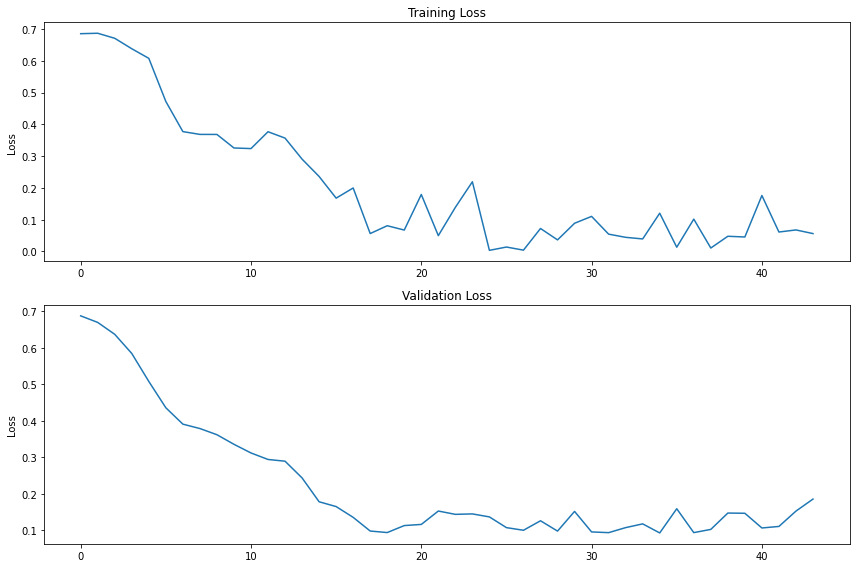

In [9]:
Main(train_X, train_Y, valid_X, valid_Y, num_epochs=4, batch_size=128)

In [10]:
Training_accuracy = predict(train_X, train_Y)
Testing_accuracy = predict(test_X, test_Y)
Validation_accuracy = predict(valid_X, valid_Y)

In [11]:
print("Training Accuracy: ",Training_accuracy,"%")
print("Testing Accuracy: ",Testing_accuracy,"%")
print("Validation Accuracy: ",Validation_accuracy,"%")

Training Accuracy:  98.071 %
Testing Accuracy:  98.333 %
Validation Accuracy:  96.5 %
